# Generative Adverserial Networks

In this notebook I am going to be creating a Generative Adverserial Network (GAN) which converts images into the style of artist Vincent Van Gogh. I am going to be using the Tensorflow framework to do this.

The outcome of this project is to create a command line application where anyone can input a desired image that they want to be converted into the style of Vincent Van Gogh.

I am going to be using the CycleGAN architecture which uses 2 GANs to create this style transfer network.

Paper reference : https://arxiv.org/pdf/1703.10593.pdf

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Download the data

First we have to download the data which we can train our GAN on.

In [4]:
data, metadata = tfds.load('cycle_gan/vangogh2photo',
                           with_info=True,
                           as_supervised=True)

In [5]:
train_van, train_photo = data['trainA'], data['trainB']
test_van, test_photo = data['testA'], data['testB']

### Visualise the data

Let's have a look at the data and visualise what we expect the outcome to be. We want to be able to convert images back and forth from one style to another.

In [6]:
sample_painting = next(iter(train_van))
sample_photo = next(iter(train_photo))

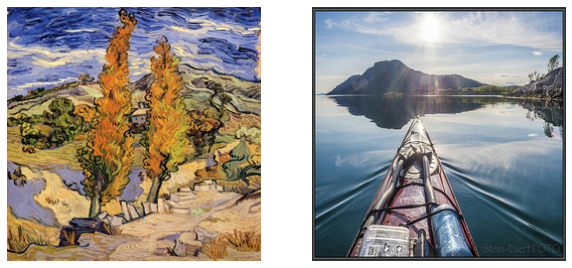

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(sample_painting[0])
ax[1].imshow(sample_photo[0])

ax[0].axis('off')
ax[1].axis('off')

plt.show()

In [8]:
def random_crop(image):
    
    return tf.image.random_crop(image, size=[256, 256, 3])

In [9]:
def normalize(image):
    
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    return image

In [10]:
def random_jitter(image):
    
    image = tf.image.resize(image, 
                            [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    image = random_crop(image)
    
    image = tf.image.random_flip_left_right(image)
    
    return image

In [11]:
def preprocess_image_train(image, label):
    
    image = random_jitter(image)
    image = normalize(image)
    
    return image

In [12]:
def preprocess_image_test(image, label):
    
    return normalize(image)

In [13]:
bs = 5

train_van = train_van.map(
preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    1000).batch(bs)

train_photo = train_photo.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    1000).batch(bs)

test_van = test_van.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    1000).batch(bs)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    1000).batch(bs)

In [14]:
sample_painting = next(iter(train_van))
sample_photo = next(iter(train_photo))

## CycleGAN

A cycleGAN consists of two GANs which work together to make sure that the input image is sufficiently similar to the output.

Each GAN has two networks, a generator G which generates images and a discriminator D which assesses the similarity of the generators output to the data distribution of the target style images.

### Generator

Let's first build the generator model.

In [15]:
def encoder_block(filters, size, batch_norm=True):
    
    '''Encoding block
       --------------
       filters : The dimensionality of the output space
       size : Size of the kernel along convolutional layer
       batch_norm : Apply batch normalization'''
    
    init = tf.random_normal_initializer(0.0, 0.02)
    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, 
                                     size,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=init,
                                     use_bias=False))
    if batch_norm:
        block.add(tfa.layers.InstanceNormalization())
        
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [16]:
def decoder_block(filters, size, dropout=False):
    
    init = tf.random_normal_initializer(0.0, 0.02)
    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2DTranspose(filters,
                                              size,
                                              strides=2,
                                              padding='same',
                                              kernel_initializer=init,
                                              use_bias=False))
    block.add(tfa.layers.InstanceNormalization())
    
    if dropout:
        
        block.add(tf.keras.layers.Dropout(0.5))
        
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [17]:
def generator():
    
    '''Generator model for the GAN'''
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    encoder_stack = [encoder_block(64, 4, batch_norm=False),
                     encoder_block(128, 4),
                     encoder_block(256, 4),
                     encoder_block(512, 4),
                     encoder_block(512, 4),
                     encoder_block(512, 4),
                     encoder_block(512, 4),
                     encoder_block(512, 4)]
    
    decoder_stack = [decoder_block(512, 4, dropout=True),
                     decoder_block(512, 4, dropout=True),
                     decoder_block(512, 4, dropout=True),
                     decoder_block(512, 4),
                     decoder_block(256, 4),
                     decoder_block(128, 4),
                     decoder_block(64, 4)]
    
    init = tf.random_normal_initializer(0.0, 0.02)
    
    last = tf.keras.layers.Conv2DTranspose(3, 
                                           4, 
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=init,
                                           activation='tanh')
    concat = tf.keras.layers.Concatenate()
    
    x = inputs
    
    skips = []
    
    for down in encoder_stack:
        
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoder_stack, skips):
        
        x = up(x)
        x = concat([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

### Discriminator

Let's build the discriminator. This is a seperate model which is trained to discriminate between real and generated image from the generator.

In [18]:
def discriminator():
    
    '''Discriminator Model for our GAN.'''
    
    init = tf.random_normal_initializer(0.0, 0.02)
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3],
                                   name='input_images')
    
    
    down1 = encoder_block(64, 4, batch_norm=False)(inputs)
    down2 = encoder_block(128, 4)(down1)
    down3 = encoder_block(256, 4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512,
                                  4,
                                  strides=1,
                                  kernel_initializer=init,
                                  use_bias=False)(zero_pad1)
    
    batch_norm1 = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1,
                                  4,
                                  strides=1,
                                  kernel_initializer=init)(zero_pad2)
    
    return tf.keras.Model(inputs=inputs, outputs=last)

In [19]:
generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

### Loss Function

As we are dealing with CycleGAN, the paper proposes a slightly tweaked loss function for this architecture.

In [20]:
L = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real, generated):
    
    real_loss = loss_obj(tf.ones_like(real), real)
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return 0.5 * total_disc_loss

In [22]:
def generator_loss(generated):
    
    return loss_obj(tf.ones_like(generated), generated)

In [23]:
def calc_cycle_loss(real_image, cycled_image):
    
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    return L * loss

In [24]:
def identity_loss(real_image, same_image):
    
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    
    return L * 0.5 * loss

### Initialize Optimizers

In [25]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Generate Sample

I am going to generate a sample before training to see what they look like. This is also for a sanity check afterwards.

In [26]:
def generate_image(model, sample, save=False, title=None):
    
    generated_image = model(sample)
    
    images = [sample[0], generated_image[0]]
    titles = ['Sampled Image', 'Generated Image']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for i in range(2):
        
        ax[i].imshow(images[i] * 0.5 + 0.5)
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    if save:
        plt.savefig('./generated_images/' + title + '.png')
    plt.show()

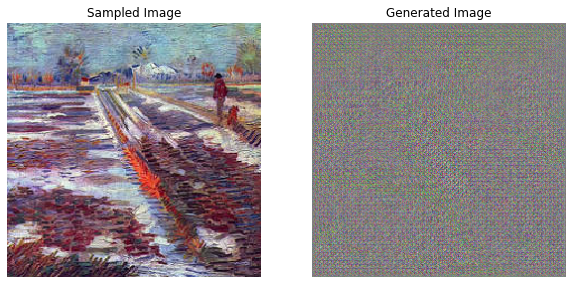

In [27]:
generate_image(generator_g, sample_painting)

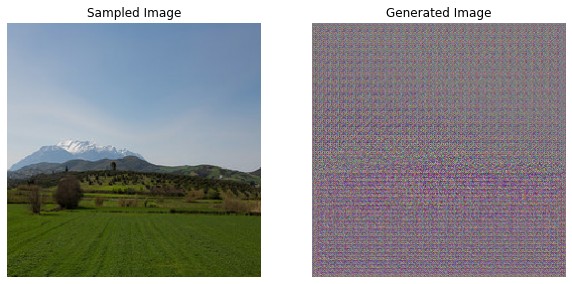

In [28]:
generate_image(generator_f, sample_photo)

Looks good to me! (This is what we would expect as the generators have not been trained.)

## Training CycleGAN

Let's use what we have defined so far to start training a CycleGAN

I am going to save the models so we can see the progression of the model at the end.

In [29]:
checkpoint_path = './checkpoints/train'

checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                                 generator_f=generator_f,
                                 discriminator_x=discriminator_x,
                                 discriminator_y=discriminator_y,
                                 generator_g_optimizer=generator_g_optimizer,
                                 generator_f_optimizer=generator_f_optimizer,
                                 discriminator_x_optimizer=discriminator_x_optimizer,
                                 discriminator_y_optimizer=discriminator_y_optimizer)

checkpoint_manager = tf.train.CheckpointManager(checkpoint,
                                                checkpoint_path,
                                                max_to_keep=5)

if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print('Latest checkpoint has been loaded.')

Latest checkpoint has been loaded.


In [30]:
def train_step(real_x, real_y):
    
    with tf.GradientTape(persistent=True) as tape:
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    

In [31]:
epoch_num = 1

for epoch in range(epoch_num):

    start = time.time()

    for image_x, image_y in tf.data.Dataset.zip((train_van, train_photo)):
    
        train_step(image_x, image_y)

    print(f'Epoch {epoch} Completed in {time.time() - start}')
    generate_image(generator_f,
                   sample_photo,
                   save=True,
                   title='Epoch_' + str(epoch))

    if (epoch + 1) % 25 == 0:

        checkpoint_save_path = checkpoint_manager.save()
        print('Saved Checkpoint')

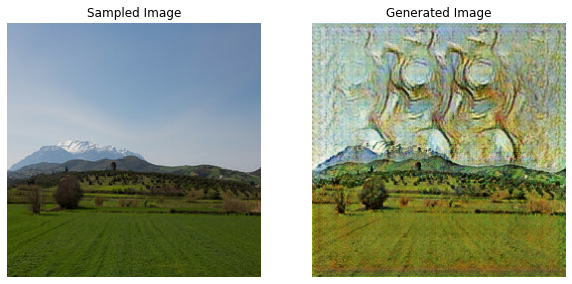

In [32]:
generate_image(generator_f, sample_photo)

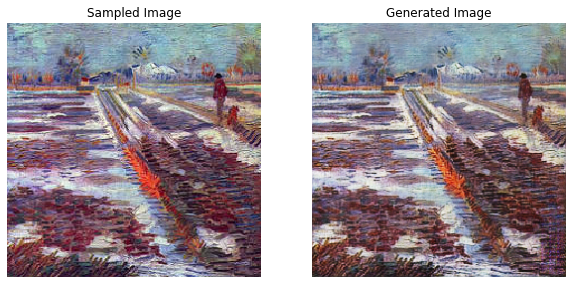

In [33]:
generate_image(generator_g, sample_painting)